In [ ]:
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers

import numpy as onp 

import qutip
import qutip.qip.operations as gates

from gate_jax import *
from circuit_ansatz_jax import *

from jupyterplot import ProgressPlot

# Hamiltonian

In [3]:
PauliBasis = jnp.array([[[1., 0.,], [0., 1.,]],
                        [[0., 1.,], [1., 0.,]],
                        [[0., -1j,], [1j, 0.,]],
                        [[1., 0.,], [0., -1.,]]], dtype=jnp.complex64)

def hamiltonian_spin_spin(num_qubit, g, h):
    ham = jnp.zeros((2 ** num_qubit, 2 ** num_qubit))
    
    # Nearest-neighbor interaction
    spin_coupling = jnp.kron(PauliBasis[3], PauliBasis[3])
    
    for i in range(num_qubit - 1):
        ham -= jnp.kron(jnp.kron(jnp.eye(2 ** i), spin_coupling), 
                        jnp.eye(2 ** (num_qubit - 2 - i)))
        ham -= jnp.kron(jnp.kron(PauliBasis[3], jnp.eye(2 ** (num_qubit - 2))), PauliBasis[3]) # Periodic B.C
    
    # Transverse magnetic field
    for i in range(num_qubit):
        ham -= g * jnp.kron(jnp.kron(jnp.eye(2 ** i), PauliBasis[1]), 
                            jnp.eye(2 ** (num_qubit - 1 - i)))

    # Longitudinal magnetic field
    for i in range(num_qubit):
        ham -= h * jnp.kron(jnp.kron(jnp.eye(2 ** i), PauliBasis[3]), 
                            jnp.eye(2 ** (num_qubit - 1 - i)))
    
    return ham

In [354]:
ham_matrix = hamiltonian_spin_spin(num_qubit=6, g=0.0, h=0)

In [355]:
eigenval, eigenftn = jnp.linalg.eigh(ham_matrix)
print("Eigenvalues: ", eigenval)
eigenftn = eigenftn.T # Transpose such that eigenftn[i] is an eigenvector, rather than eigenftn[:, i]

Eigenvalues:  [-10. -10.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.
  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   6.   6.   6.   6.   6.   6.   6.   6.   6.   6.   6.   6.   6.   6.
   6.   6.   6.   6.   6.   6.  10.  10.]


In [356]:
def energy(hamiltonian, state):
    return jnp.real(state.T.conj() @ hamiltonian @ state)

In [357]:
energy(ham_matrix, eigenftn[0])

DeviceArray(-10., dtype=float32)

## Circuit Ansatz

In [414]:
LAYER=24

In [415]:
rng = jax.random.PRNGKey(1)
rng, params = init_params(rng, n_qubit=6, n_layer=LAYER)

In [416]:
ansatz_state = alternating_layer_ansatz(params, n_qubit=6, s_block=6, n_layer=LAYER)
print("State: ", ansatz_state)
print("State norm: ", ansatz_state.T.conj() @ ansatz_state)
print("Energy: ", energy(ham_matrix, ansatz_state))

State:  [-0.16221604-0.09014717j  0.07595157-0.14910454j  0.03036386+0.12367344j
 -0.02946852-0.11299641j -0.1595134 -0.0499148j  -0.1226873 +0.07486317j
 -0.02325038-0.09881446j  0.05762791-0.06917239j -0.11469616+0.0110104j
  0.18436581-0.07649445j  0.02377897+0.02147411j -0.07432015+0.10863836j
 -0.07360395-0.0206121j   0.02428296+0.12804168j -0.04179693+0.0575238j
 -0.11639116+0.11676569j -0.06554835+0.08630455j -0.05425795-0.06837811j
 -0.00518904-0.05793377j -0.09921239+0.08257359j -0.0368409 -0.03546049j
  0.00881204-0.05643304j -0.04298962+0.04736042j -0.08926048-0.0341699j
 -0.10967313+0.07208578j -0.07898   +0.0556403j  -0.05124762+0.19358245j
 -0.1842593 -0.07305253j -0.03405157+0.02363445j  0.08959377+0.05677393j
  0.03935372+0.00416081j -0.03087433+0.0893805j   0.1123357 -0.15125188j
 -0.00228449+0.19471695j  0.13878515+0.11669638j  0.06869386-0.14217557j
 -0.08202788-0.15693419j  0.17841358-0.01458791j -0.02159753-0.14993435j
 -0.01394858-0.02221283j  0.07604775-0.0638626

## Finding ground state

In [417]:
def loss(params, n_qubit, s_block, n_layer, rot_axis, hamiltonian):
    ansatz_state = alternating_layer_ansatz(params, n_qubit, s_block, n_layer, rot_axis)
    return energy(ham_matrix, ansatz_state)

def fidelity(params, n_qubit, s_block, n_layer, rot_axis, target_state):
    ansatz_state = alternating_layer_ansatz(params, n_qubit, s_block, n_layer, rot_axis)
    return jnp.abs(ansatz_state.T.conj() @ target_state) ** 2, ansatz_state

Our target function (to be minimized) is the energy, of course.

In [27]:
loss(params, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', hamiltonian=ham_matrix)

DeviceArray(-0.5508515, dtype=float32)

Taking gradient w.r.t circuit parameters is super simple

In [162]:
jax.grad(loss)(params, n_qubit=4, s_block=4, n_layer=2, rot_axis='Y', hamiltonian=ham_matrix)

DeviceArray([-0.15392366, -0.6933206 , -0.1273463 , -0.1408144 ,
              0.4887835 , -1.1236221 , -0.40086204,  1.7966585 ],            dtype=float32)

Gradient descent can be implemented as follows.

In [418]:
def step(step_num, opt_state, **kwargs):
    params = get_params(opt_state)
    loss_v, grad_v = jax.value_and_grad(loss)(params, **kwargs)
    return loss_v, opt_update(step_num, grad_v, opt_state)

In [419]:
opt_init, opt_update, get_params = optimizers.adam(0.01)
opt_state = opt_init(params)
loss_history = []

In [420]:
pp = ProgressPlot() # JupyterPlot

for train_step in range(10000):
    loss_v, opt_state = step(train_step, opt_state, n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', hamiltonian=ham_matrix)
    loss_history.append(loss_v.item())
    pp.update(loss_v.item()) # Real-time update of the plot
    
    # Stopping condition
    if train_step > 101:
        if jnp.mean(jnp.array(loss_history[-101:-1]) - 
                    jnp.array(loss_history[-100:])) < 1e-9: 
            break

pp.finalize()

# 4 qubits

## 4 layers

In [347]:
print(f"Exact ground state energy: {eigenval[0]}")
print(f"(Averaged)  loss: {jnp.mean(jnp.array(loss_history[-10:]))}")
print(f"{train_step} steps")
res = fidelity(get_params(opt_state), n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])
print(res[0])

Exact ground state energy: -6.0
(Averaged)  loss: -5.819706439971924
753 steps
0.08615965


In [230]:
print(get_params(opt_state))

[ 4.0042424  4.5511823  6.020628   1.6850972  4.537494   3.8572524
  5.2025185  2.5633132  1.2255272 -0.5858624  4.909773   0.767567
  6.370156   4.8626733  5.4306526  1.5517302]


In [348]:
hess = jax.hessian(loss)(get_params(opt_state), n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', hamiltonian=ham_matrix)

In [349]:
hess_eig4= onp.sort(onp.linalg.eigvals(onp.array(hess)))
print(onp.round(hess_eig4,2))

[0.16 0.26 0.33 0.51 0.81 1.53 1.59 2.06 2.21 2.9  4.19 4.54 5.4  6.03
 7.34 8.12]


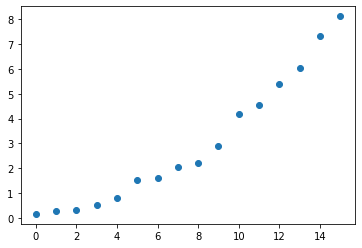

In [25]:
import pylab as plt 
plt.plot(hess_eig4, 'o')
plt.show()

In [350]:
eigval_hess, eigftn_hess = jnp.linalg.eigh(hess)
eigftn_hess = eigftn_hess.T

In [254]:
@jax.vmap
def state_along_flat(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[2]
    return fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])[0] + \
           fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[1])[0]

0th and 1th (most flat...)

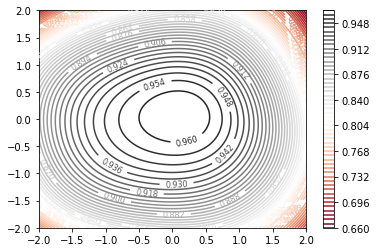

In [52]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z = state_along_flat(A.flatten(), B.flatten()).reshape(100, 100)

contours = plt.contour(A, B, Z, 50, cmap='RdGy')
plt.colorbar()
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

0th and 5th

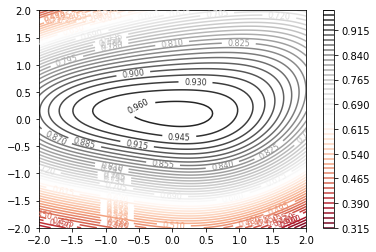

In [55]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z = state_along_flat(A.flatten(), B.flatten()).reshape(100, 100)

contours = plt.contour(A, B, Z, 50, cmap='RdGy')
plt.colorbar()
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

#### Fidelity with individual ground states

In [351]:
onp.sort(eigval_hess)

array([0.16207808, 0.2606949 , 0.3348816 , 0.5132668 , 0.8123805 ,
       1.5273174 , 1.5914993 , 2.055565  , 2.2090092 , 2.9004788 ,
       4.188882  , 4.54132   , 5.3997803 , 6.027043  , 7.3391647 ,
       8.124044  ], dtype=float32)

In [352]:
@jax.vmap
def state_along_flat_0(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])[0] 

@jax.vmap
def state_along_flat_1(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[1])[0] 

0th and 1th (most flat...)

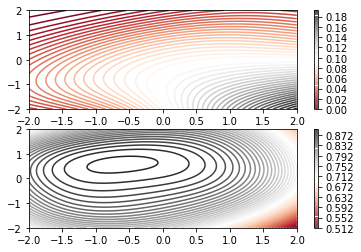

In [353]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z0 = state_along_flat_0(A.flatten(), B.flatten()).reshape(100, 100)
Z1 = state_along_flat_1(A.flatten(), B.flatten()).reshape(100, 100)

fig, ax = plt.subplots(2, 1)
f1 = ax[0].contour(A, B, Z0, 50, cmap='RdGy')
plt.colorbar(f1, ax=ax[0])
f2 = ax[1].contour(A, B, Z1, 50, cmap='RdGy')
plt.colorbar(f2)
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

### 8 layers

In [266]:
print(f"Exact ground state energy: {eigenval[0]}")
print(f"(Averaged)  loss: {jnp.mean(jnp.array(loss_history[-10:]))}")
print(f"{train_step} steps")
res = fidelity(get_params(opt_state), n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])
print(res[0])

Exact ground state energy: -6.0
(Averaged)  loss: -6.000001907348633
958 steps
0.7510636


In [267]:
print(get_params(opt_state))

[ 2.0197856   4.629784    3.2983003   3.4623938   1.3041927   6.0432105
  6.359264    4.720966    4.544391    1.9112086   2.0124302   5.9848056
  1.8889941   0.01143088  0.870981    1.1509376   4.2685766   4.4604363
 -0.3720333   3.2945893   0.16268626  3.7551975   1.3342282   1.7282215
  3.141138    4.847985    4.6113315   6.936646    3.0463355   2.7678933
  2.1671088   3.365254  ]


In [272]:
hess = jax.hessian(loss)(get_params(opt_state), n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', hamiltonian=ham_matrix)

In [273]:
hess_eig8= onp.sort(onp.linalg.eigvals(onp.array(hess)))
print(onp.round(hess_eig8,2))

[-0.   -0.    0.    0.    0.03  0.04  0.09  0.13  0.19  0.29  0.41  0.54
  0.63  0.93  1.25  1.31  1.58  2.02  2.29  2.53  2.75  3.03  3.16  4.07
  4.46  5.01  5.97  7.49  8.47 10.9  11.46 12.93]


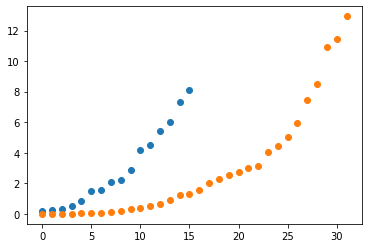

In [67]:
plt.plot(hess_eig4, 'o')
plt.plot(hess_eig8, 'o')
plt.show()

In [276]:
eigval_hess, eigftn_hess = jnp.linalg.eigh(hess)
eigftn_hess = eigftn_hess.T

In [84]:
@jax.vmap
def state_along_flat(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[4]
    return fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])[0] + \
           fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[1])[0]

0th and 1th (most flat...)

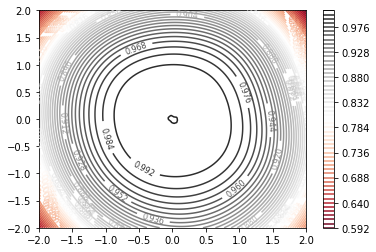

In [81]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z = state_along_flat(A.flatten(), B.flatten()).reshape(100, 100)

contours = plt.contour(A, B, Z, 50, cmap='RdGy')
plt.colorbar()
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

0th and 4th

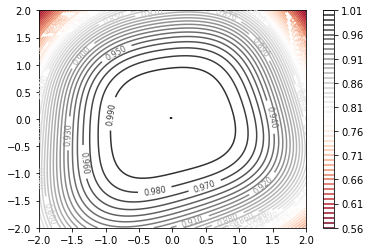

In [85]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z = state_along_flat(A.flatten(), B.flatten()).reshape(100, 100)

contours = plt.contour(A, B, Z, 50, cmap='RdGy')
plt.colorbar()
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

#### Fidelity with individual ground states

In [311]:
onp.sort(eigval_hess)

array([-6.6330860e-04, -9.7194221e-05,  8.0731668e-05,  6.2342756e-04,
        2.9582217e-02,  3.8657095e-02,  8.5806586e-02,  1.2908562e-01,
        1.9044589e-01,  2.8910220e-01,  4.0501624e-01,  5.4004693e-01,
        6.3435054e-01,  9.2545354e-01,  1.2532409e+00,  1.3121592e+00,
        1.5770589e+00,  2.0168152e+00,  2.2934809e+00,  2.5251853e+00,
        2.7524462e+00,  3.0340965e+00,  3.1560700e+00,  4.0731573e+00,
        4.4611721e+00,  5.0120158e+00,  5.9726486e+00,  7.4859695e+00,
        8.4745913e+00,  1.0898049e+01,  1.1461352e+01,  1.2934529e+01],
      dtype=float32)

In [338]:
@jax.vmap
def state_along_flat_0(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])[0] 

@jax.vmap
def state_along_flat_1(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=4, s_block=4, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[1])[0] 

0th and 1th (most flat...)

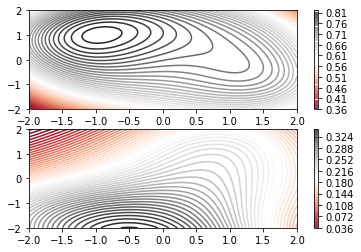

In [339]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z0 = state_along_flat_0(A.flatten(), B.flatten()).reshape(100, 100)
Z1 = state_along_flat_1(A.flatten(), B.flatten()).reshape(100, 100)

fig, ax = plt.subplots(2, 1)
f1 = ax[0].contour(A, B, Z0, 50, cmap='RdGy')
plt.colorbar(f1, ax=ax[0])
f2 = ax[1].contour(A, B, Z1, 50, cmap='RdGy')
plt.colorbar(f2)
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

# 6 qubits

## 6 layers

In [406]:
print(f"Exact ground state energy: {eigenval[0]}")
print(f"(Averaged)  loss: {jnp.mean(jnp.array(loss_history[-10:]))}")
print(f"{train_step} steps")
res = fidelity(get_params(opt_state), n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])
print(res[0])

Exact ground state energy: -10.0
(Averaged)  loss: -9.999994277954102
1268 steps
3.292899e-39


In [407]:
print(get_params(opt_state))

[ 4.1317849e+00  3.1415923e+00  3.1415923e+00 -4.0885939e-07
  3.1355002e+00  2.9174824e+00  4.8849463e-01  3.1415923e+00
  3.1415932e+00  3.1415930e+00  6.2775960e+00  2.5740929e+00
  2.4083352e+00  3.1415923e+00  6.2831860e+00  3.1415927e+00
  3.1378453e+00  1.2906510e+00  6.2625685e+00  6.2831855e+00
  6.2831864e+00  6.2831860e+00  3.1484733e+00  1.4543266e+00
  3.6525631e+00  3.1415925e+00  6.2831864e+00  3.1415942e+00
  5.2754772e-01 -1.3371880e-01  3.1392176e+00 -1.9081206e-07
  6.2831860e+00  3.1415935e+00  3.6658015e+00  3.1578226e+00]


In [408]:
hess = jax.hessian(loss)(get_params(opt_state), n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', hamiltonian=ham_matrix)

In [409]:
hess_eig6= onp.sort(onp.linalg.eigvals(onp.array(hess)))
print(onp.round(hess_eig6,2))

[-0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  2.000e-02
  9.000e-02  1.200e-01  2.400e-01  4.100e-01  4.900e-01  5.000e-01
  7.000e-01  7.500e-01  7.600e-01  8.700e-01  1.080e+00  1.600e+00
  1.780e+00  2.180e+00  2.590e+00  2.680e+00  3.230e+00  3.390e+00
  4.980e+00  5.050e+00  5.220e+00  5.580e+00  6.300e+00  7.800e+00
  9.720e+00  1.033e+01  1.235e+01  1.353e+01  1.783e+01  2.282e+01]


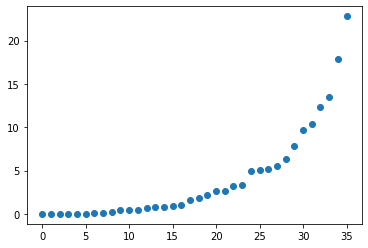

In [410]:
import pylab as plt 
plt.plot(hess_eig6, 'o')
plt.show()

In [411]:
eigval_hess, eigftn_hess = jnp.linalg.eigh(hess)
eigftn_hess = eigftn_hess.T

In [412]:
@jax.vmap
def state_along_flat_0(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])[0] 

@jax.vmap
def state_along_flat_1(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[1])[0] 

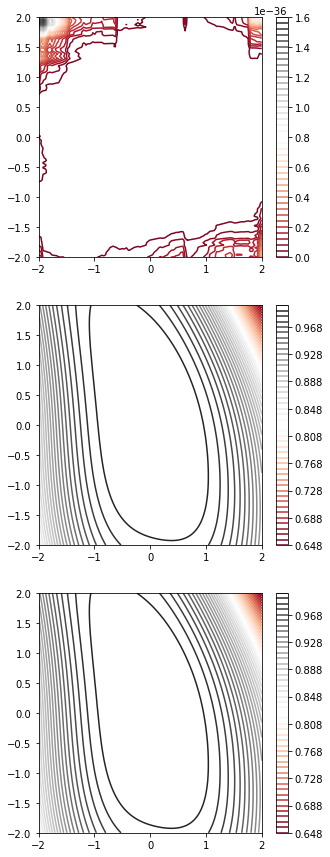

In [413]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z0 = state_along_flat_0(A.flatten(), B.flatten()).reshape(100, 100)
Z1 = state_along_flat_1(A.flatten(), B.flatten()).reshape(100, 100)

fig, ax = plt.subplots(3, 1,figsize=(5,15))
f1 = ax[0].contour(A, B, Z0, 50, cmap='RdGy')
plt.colorbar(f1, ax=ax[0])
f2 = ax[1].contour(A, B, Z1, 50, cmap='RdGy')
plt.colorbar(f2, ax=ax[1])
f3 = ax[2].contour(A, B, Z0 + Z1, 50, cmap='RdGy')
plt.colorbar(f3)
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

## 12 layers

In [387]:
print(f"Exact ground state energy: {eigenval[0]}")
print(f"(Averaged)  loss: {jnp.mean(jnp.array(loss_history[-10:]))}")
print(f"{train_step} steps")
res = fidelity(get_params(opt_state), n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])
print(res[0])

Exact ground state energy: -10.0
(Averaged)  loss: -9.54631233215332
827 steps
0.649451


In [388]:
print(get_params(opt_state))

[0.5661969  6.3561997  2.2395883  4.6043096  5.9980507  2.9075522
 2.6551669  4.141961   5.7192354  5.4290166  0.04594142 4.6784005
 6.3947906  0.10624077 2.4081953  5.490658   2.8215497  5.8436418
 0.19940391 2.816742   2.9779081  1.6750113  4.0737324  1.6298847
 3.5875378  0.38748702 4.4716926  0.3768177  1.7633246  1.4754727
 5.477859   5.3743424  4.828266   1.4746562  4.3138256  6.6126146
 5.944827   5.5155463  1.5074868  4.4399605  5.3402843  4.3005595
 4.883959   6.182564   1.106982   2.3985722  3.028362   4.6733336
 5.509728   2.6349497  2.0861526  1.4126486  3.8781154  3.135018
 4.2018085  4.7403007  1.5410295  2.5797586  0.22221023 5.4726696
 5.495992   3.824712   6.0193615  0.5336854  4.8083863  1.1221313
 3.9729273  2.1458175  1.3708295  1.3864284  6.1394706  5.686899  ]


In [389]:
hess = jax.hessian(loss)(get_params(opt_state), n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', hamiltonian=ham_matrix)

In [390]:
hess_eig12= onp.sort(onp.linalg.eigvals(onp.array(hess)))
print(onp.round(hess_eig12,2))

[-0.05  0.18  0.19  0.22  0.3   0.33  0.43  0.44  0.48  0.55  0.6   0.68
  0.79  0.83  0.86  0.88  0.93  1.03  1.12  1.26  1.3   1.43  1.46  1.54
  1.6   1.71  1.81  2.01  2.1   2.18  2.3   2.4   2.55  2.59  2.77  2.79
  2.85  3.03  3.26  3.31  3.55  3.64  3.92  4.21  4.36  4.47  4.64  4.98
  5.3   5.63  5.9   6.18  6.21  6.68  6.74  7.13  7.7   8.07  8.33  8.49
  9.1   9.52  9.86 10.66 11.06 11.62 12.42 13.25 14.42 15.04 16.5  18.6 ]


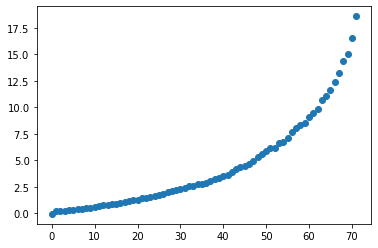

In [391]:
import pylab as plt 
plt.plot(hess_eig12, 'o')
plt.show()

In [392]:
eigval_hess, eigftn_hess = jnp.linalg.eigh(hess)
eigftn_hess = eigftn_hess.T

In [398]:
@jax.vmap
def state_along_flat_0(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])[0] 

@jax.vmap
def state_along_flat_1(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[1])[0] 

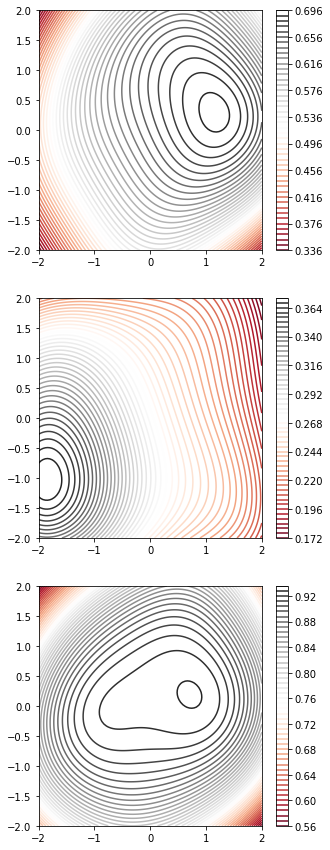

In [399]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z0 = state_along_flat_0(A.flatten(), B.flatten()).reshape(100, 100)
Z1 = state_along_flat_1(A.flatten(), B.flatten()).reshape(100, 100)

fig, ax = plt.subplots(3, 1,figsize=(5,15))
f1 = ax[0].contour(A, B, Z0, 50, cmap='RdGy')
plt.colorbar(f1, ax=ax[0])
f2 = ax[1].contour(A, B, Z1, 50, cmap='RdGy')
plt.colorbar(f2, ax=ax[1])
f3 = ax[2].contour(A, B, Z0 + Z1, 50, cmap='RdGy')
plt.colorbar(f3)
plt.clabel(contours, inline=True, fontsize=8)
plt.show()

## 24 layers

In [421]:
print(f"Exact ground state energy: {eigenval[0]}")
print(f"(Averaged)  loss: {jnp.mean(jnp.array(loss_history[-10:]))}")
print(f"{train_step} steps")
res = fidelity(get_params(opt_state), n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])
print(res[0])

Exact ground state energy: -10.0
(Averaged)  loss: -10.000021934509277
780 steps
0.76847476


In [422]:
print(get_params(opt_state))

[ 3.093445    1.6305325   4.293142    0.28930506  0.02204948  2.9627488
  1.1278417   4.958543    0.52471715  2.43434     5.8563523   1.2760571
  3.3047376   5.231316    4.0751567   2.0545976   5.099309   -0.23478599
  2.2671897   2.0998437   3.8764243   2.5787296   6.1063976   2.2167425
  0.6681829   6.510052    1.7358834   5.5149393   0.4869353   1.5793118
  4.6736083   1.5146645   2.526273    5.973617    2.227575    0.16004124
  4.396849    1.1224316   4.314925    3.327565    3.2146041   1.7028025
  5.145078    0.72300357  0.78723454  3.3726702   2.5764947   5.1125045
  4.2650924   5.6803026   2.6829135   3.680457    2.0819955   1.9990995
  2.5808582   4.835424    1.474273    1.2132097   3.1124809   3.3483727
  3.8887756   2.232111    1.4929016   0.6634756   3.0093772   4.850072
  2.367338    6.0172496   4.899944    4.764511    4.5302205   0.2703025
  2.695324    5.659491    3.426123    6.2113733   1.1777908   3.772924
  5.770804    4.802256    5.8492846   5.729413    4.2776647   4.

In [423]:
hess = jax.hessian(loss)(get_params(opt_state), n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', hamiltonian=ham_matrix)

In [424]:
hess_eig12= onp.sort(onp.linalg.eigvals(onp.array(hess)))
print(onp.round(hess_eig12,2))

[-0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.04  0.04  0.06  0.08
  0.09  0.1   0.11  0.12  0.14  0.17  0.21  0.21  0.23  0.25  0.27  0.3
  0.33  0.37  0.38  0.44  0.47  0.48  0.49  0.57  0.62  0.64  0.67  0.7
  0.74  0.79  0.84  0.86  0.91  0.93  0.97  1.08  1.17  1.21  1.25  1.34
  1.38  1.45  1.51  1.54  1.57  1.61  1.68  1.76  1.85  1.94  2.04  2.1
  2.15  2.22  2.42  2.51  2.57  2.67  2.81  2.81  2.93  3.06  3.22  3.33
  3.41  3.53  3.71  3.8   3.83  4.16  4.22  4.35  4.54  4.55  4.67  4.84
  5.16  5.23  5.36  5.6   5.81  6.04  6.24  6.36  6.69  6.95  7.1   7.32
  7.74  7.83  7.97  8.15  8.38  8.64  9.13  9.22  9.59  9.64 10.17 10.51
 11.19 11.33 11.54 12.06 12.34 12.68 13.04 13.92 14.13 14.81 14.97 15.63
 15.89 16.66 17.05 17.6  17.85 18.66 19.   19.25 21.9  23.12 23.48 25.44]


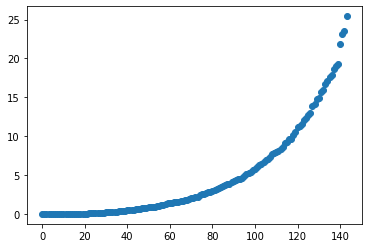

In [425]:
import pylab as plt 
plt.plot(hess_eig12, 'o')
plt.show()

In [426]:
eigval_hess, eigftn_hess = jnp.linalg.eigh(hess)
eigftn_hess = eigftn_hess.T

In [427]:
@jax.vmap
def state_along_flat_0(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[0])[0] 

@jax.vmap
def state_along_flat_1(alpha, beta):
    state = get_params(opt_state) + alpha * eigftn_hess[0] + beta * eigftn_hess[1]
    return fidelity(state, n_qubit=6, s_block=6, n_layer=LAYER, rot_axis='Y', target_state=eigenftn[1])[0] 

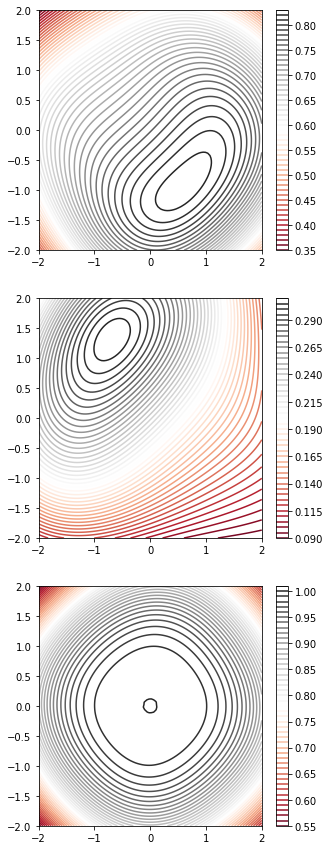

In [428]:
alpha = onp.linspace(-2, 2, 100)
beta = onp.linspace(-2, 2, 100)

A, B = onp.meshgrid(alpha, beta)
Z0 = state_along_flat_0(A.flatten(), B.flatten()).reshape(100, 100)
Z1 = state_along_flat_1(A.flatten(), B.flatten()).reshape(100, 100)

fig, ax = plt.subplots(3, 1,figsize=(5,15))
f1 = ax[0].contour(A, B, Z0, 50, cmap='RdGy')
plt.colorbar(f1, ax=ax[0])
f2 = ax[1].contour(A, B, Z1, 50, cmap='RdGy')
plt.colorbar(f2, ax=ax[1])
f3 = ax[2].contour(A, B, Z0 + Z1, 50, cmap='RdGy')
plt.colorbar(f3)
plt.clabel(contours, inline=True, fontsize=8)
plt.show()